In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization

from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model

In [2]:
print(os.listdir('../input/digit-recognizer'))

['sample_submission.csv', 'train.csv', 'test.csv']


In [3]:
train = pd.read_csv('../input/digit-recognizer/train.csv')
test = pd.read_csv('../input/digit-recognizer/test.csv')
sub = pd.read_csv('../input/digit-recognizer/sample_submission.csv')

In [4]:
print(f"Training data size is {train.shape}\nTesting data size is {test.shape}")

Training data size is (42000, 785)
Testing data size is (28000, 784)


In [5]:
X = train.drop(['label'], axis = 1).values
y = train['label'].values

In [6]:
X = X / 255.0

In [7]:
X = X.reshape(-1, 28, 28, 1)

In [8]:
y = to_categorical(y)

print(f"Label size {y.shape}")

Label size (42000, 10)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

X_train = tf.image.resize(X_train, [227, 227]) # if we want to resize 
X_test = tf.image.resize(X_test, [227, 227]) # if we want to resize 

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(TensorShape([37800, 227, 227, 1]),
 TensorShape([4200, 227, 227, 1]),
 (37800, 10),
 (4200, 10))

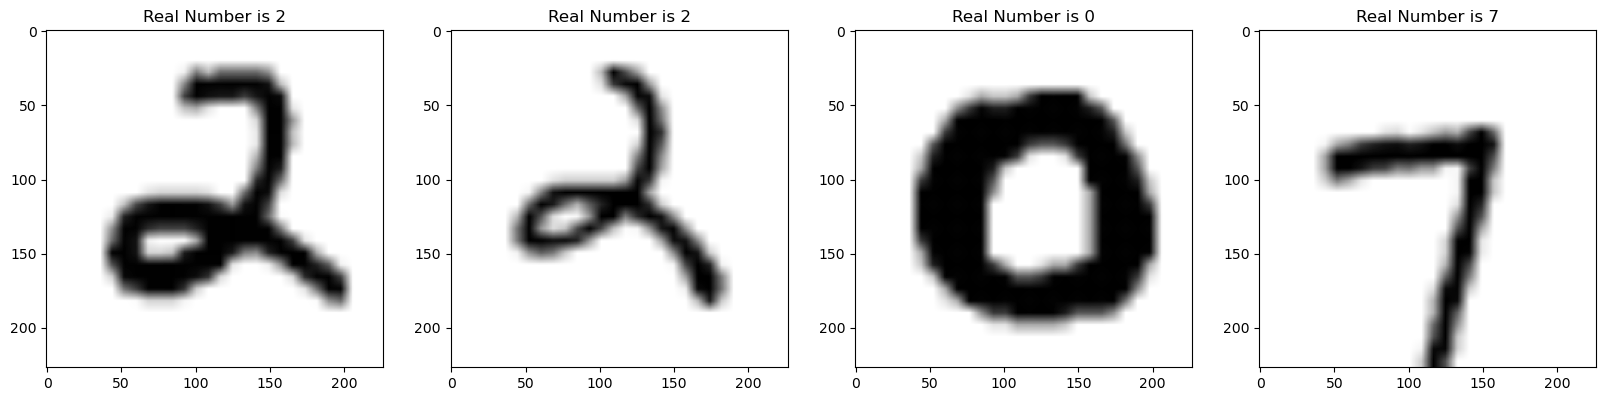

In [12]:
X_train__ = tf.reshape(X_train, [X_train.shape[0], 227, 227])

fig, axis = plt.subplots(1, 4, figsize=(20, 10))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_train__[i], cmap='binary')
    digit = y_train[i].argmax()
    ax.set(title = f"Real Number is {digit}");

In [13]:
class AlexNet(tf.keras.Model):
    
    def __init__(self, num_classes = 10):
        super(AlexNet, self).__init__()
        self.conv1 = Conv2D(filters = 96, kernel_size=(11,11), strides=(4,4), activation='relu')
        self.pool1 = MaxPooling2D(pool_size=(3,3), strides=(2,2))
        self.conv2 = Conv2D(filters = 256, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu')
        self.pool2 = MaxPooling2D(pool_size=(3,3), strides=(2,2))
        self.conv3 = Conv2D(filters = 384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')
        self.conv4 = Conv2D(filters = 384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')
        self.conv5 = Conv2D(filters = 256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')
        self.pool3 = MaxPooling2D(pool_size=(3,3), strides=(2,2))
        self.flatten = Flatten()
        self.fc1 = Dense(units = 4096, activation='relu')
        self.dropout1 = Dropout(0.5)
        self.fc2 = Dense(units = 4096, activation='relu')
        self.dropout2 = Dropout(0.5)
        self.fc3 = Dense(units = num_classes, activation='softmax')

    def call(self, input_tensor):
        x = self.conv1(input_tensor)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        
        return x

input_layer = Input(shape  = (227, 227, 1))
x = AlexNet()(input_layer)
model = Model(inputs = input_layer, outputs = x)

print(model.summary(expand_nested = True))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 1)]     0         
                                                                 
 alex_net (AlexNet)          (None, 10)                58299082  
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv2d (Conv2D)           multiple                  11712     |
|                                                               |
| max_pooling2d (MaxPooling2D  multiple               0         |
| )                                                             |
|                                                               |
| conv2d_1 (Conv2D)         multiple                  614656    |
|                                                               |
| max_pooling2d_1 (MaxPooling  multiple               0         |
| 2D)                                                        

In [14]:
model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = tf.keras.metrics.CategoricalAccuracy(),
    optimizer = tf.keras.optimizers.Adam()
)

In [15]:
datagen = ImageDataGenerator(
    featurewise_center = False,  # set input mean to 0 over the dataset
    samplewise_center = False,  # set each sample mean to 0
    featurewise_std_normalization = False,  # divide inputs by std of the dataset
    samplewise_std_normalization = False,  # divide each input by its std
    zca_whitening = False,  # apply ZCA whitening
    rotation_range = 15,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.01, # Randomly zoom image 
    width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = False,  # randomly flip images
    vertical_flip = False
)  # randomly flip images


#datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size = 128)
test_gen = datagen.flow(X_test, y_test, batch_size = 128)

In [16]:
epochs = 2
batch_size = 128
train_steps = X_train.shape[0] // batch_size
valid_steps = X_test.shape[0] // batch_size

es = tf.keras.callbacks.EarlyStopping(
        monitor = "val_categorical_acc", # metrics to monitor
        patience = 2, # how many epochs before stop
        verbose = 1,
        mode = "max", # we need the maximum accuracy.
        restore_best_weights = True, # 
     )

In [17]:
history = model.fit(train_gen, 
                    epochs = epochs, 
                    steps_per_epoch = train_steps,
                    validation_data = test_gen,
                    validation_steps = valid_steps, 
                    callbacks = [es])

Epoch 1/2
295/295 [==============================] - 166s 529ms/step - loss: 0.5623 - categorical_accuracy: 0.8057 - val_loss: 0.1098 - val_categorical_accuracy: 0.9631
Epoch 2/2
295/295 [==============================] - 154s 523ms/step - loss: 0.1054 - categorical_accuracy: 0.9673 - val_loss: 0.0802 - val_categorical_accuracy: 0.9746


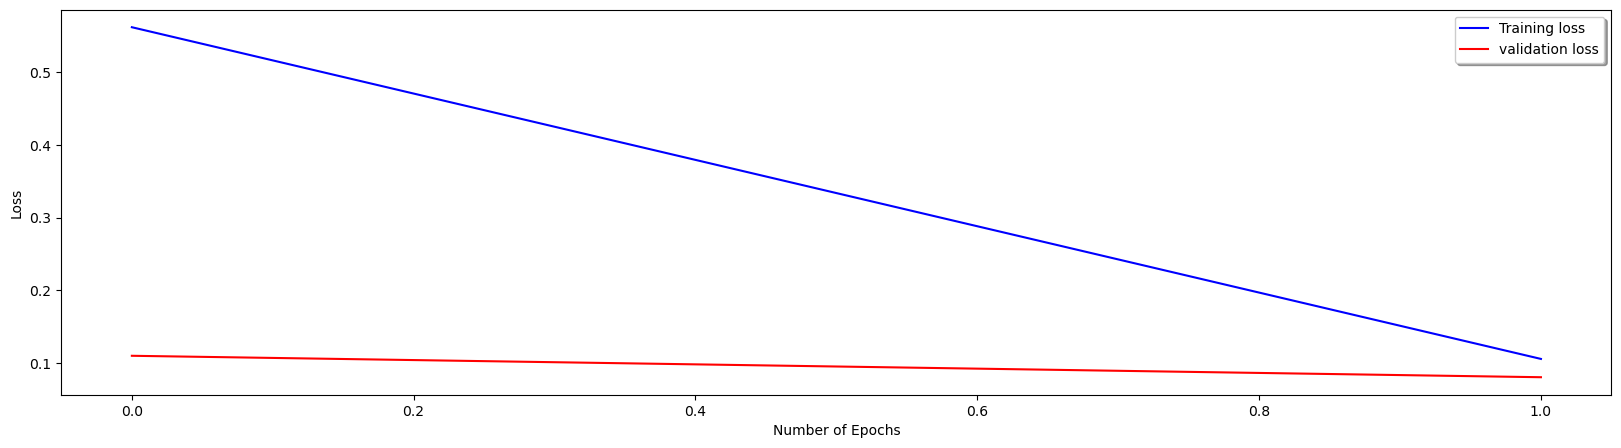

In [37]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(1,1, figsize=(20, 5))
ax.plot(history.history['loss'], color='b', label="Training loss")
ax.plot(history.history['val_loss'], color='r', label="validation loss",axes = ax)
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
legend = ax.legend(loc='best', shadow=True)

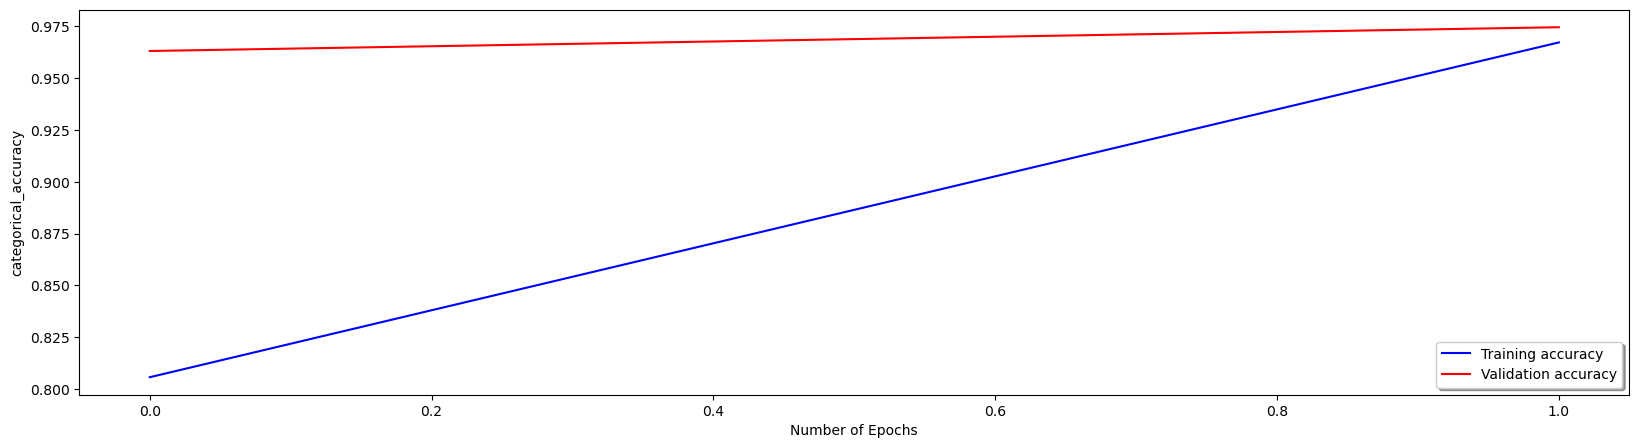

In [38]:
fig, ax = plt.subplots(1,1, figsize=(20, 5))
ax.plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
ax.plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("categorical_accuracy")
legend = ax.legend(loc = 'best', shadow = True)

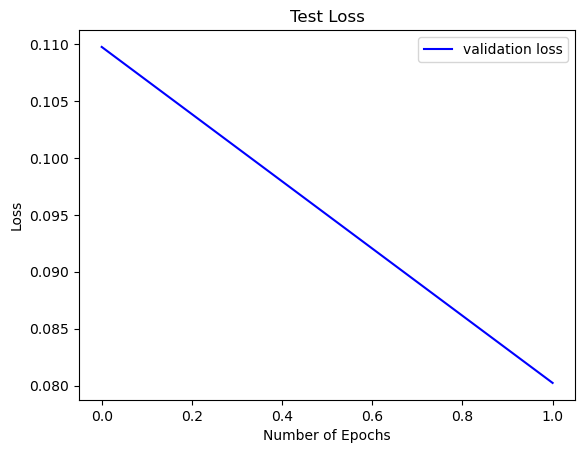

In [23]:
# Plot the loss and accuracy curves for training and validation 
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

132/132 [==============================] - 2s 9ms/step


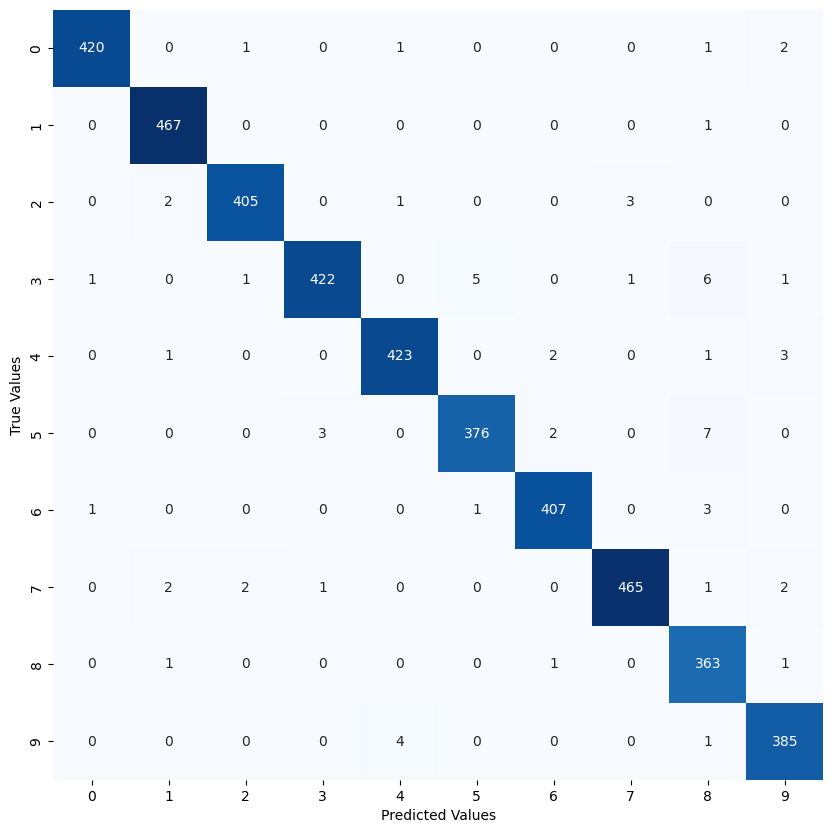

In [22]:
fig = plt.figure(figsize=(10, 10)) # Set Figure

y_pred = model.predict(X_test) # Predict class probabilities as 2 => [0.1, 0, 0.9, 0, 0, 0, 0, 0, 0, 0]

Y_pred = np.argmax(y_pred, 1) # Decode Predicted labels
Y_test = np.argmax(y_test, 1) # Decode labels

mat = confusion_matrix(Y_test, Y_pred) # Confusion matrix

# Plot Confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

132/132 [==============================] - 1s 9ms/step


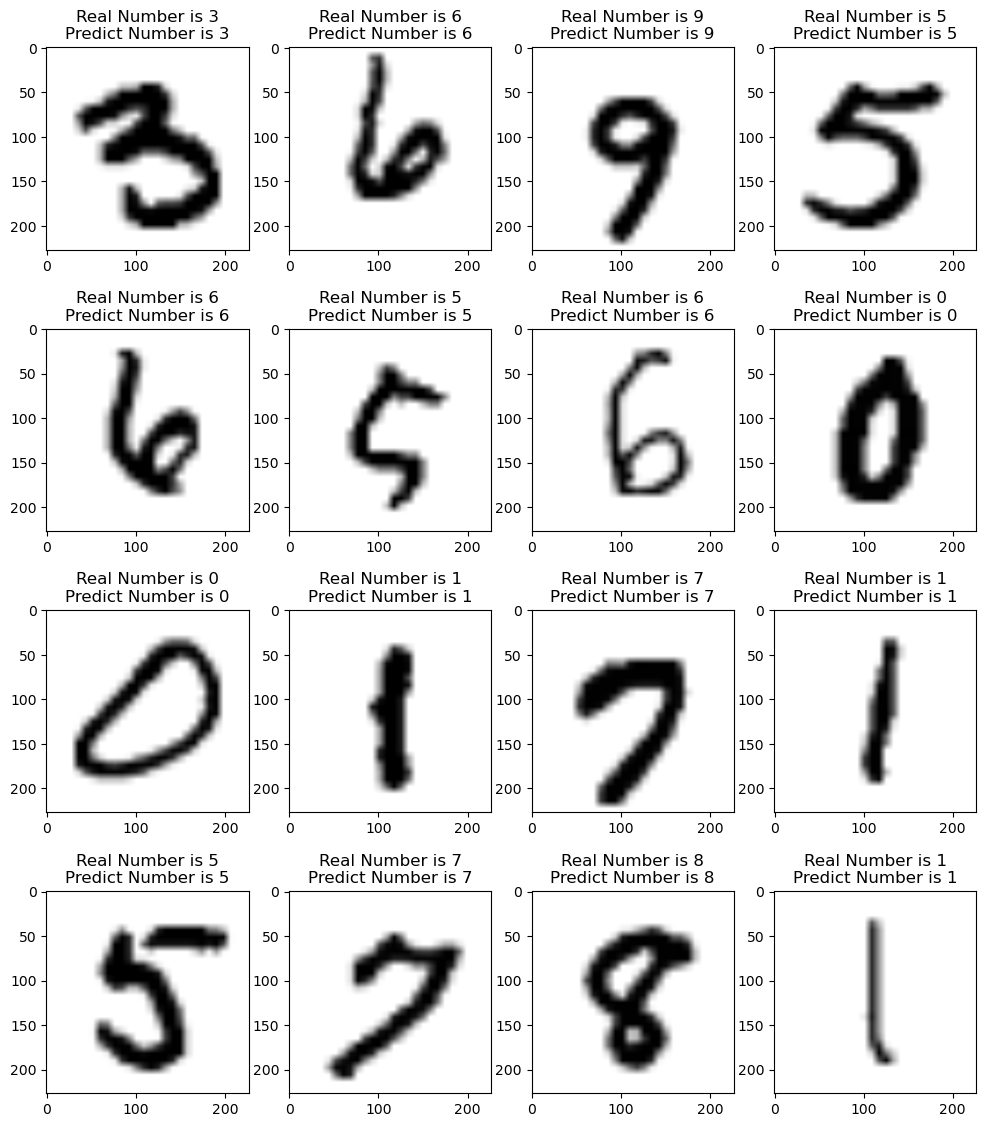

In [26]:
y_pred = model.predict(X_test)
X_test__ = tf.reshape(X_test, [X_test.shape[0], 227, 227])

fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title = f"Real Number is {y_test[i].argmax()}\nPredict Number is {y_pred[i].argmax()}");